## 02_model_dev.ipynb
## 🚀 Model Development: Credit Card Fraud Detection
## Using Logistic Regression & LightGBM

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
import joblib

# Load and prepare data
df = pd.read_csv('../data/processed/creditcard_clean.csv')

# 🧼 Clean column names globally to avoid LightGBM JSON issues
df.columns = [str(col).replace(':', '_').replace(' ', '_').replace('"', '').replace("'", '').replace('[', '').replace(']', '').replace('(', '').replace(')', '') for col in df.columns]

# 🧼 Encode non-numeric categorical features if any
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# 🎯 Separate Features and Target
# Drop non-numeric or encoded bin columns that may break LightGBM
columns_to_drop = [col for col in df.columns if any(substr in col for substr in ['bin', 'interval', 'bucket']) or df[col].dtype == 'object']
df = df.drop(columns=columns_to_drop)

X = df.drop('Class', axis=1)
y = df['Class']

In [2]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(227845, 36) (56962, 36) (227845,) (56962,)


In [3]:
X_train.head()

,V14,V4,V12,V10,V1,V17,V11,V2,hour,is_night,...,outlier_count,is_high_risk_amount,is_night_high_amount,hour_segment_evening,hour_segment_morning,hour_segment_night,hour_segment,V14*V17,V10^2,V12/V14
265518,-0.066555,-0.661630,0.510277,-0.157403,1.946747,-0.765670,-0.113729,-0.752526,20.0,0,...,0,1,0,True,False,False,1,0.050959,0.024776,-7.668140
180305,0.721068,0.247945,0.325560,0.284864,2.035149,-0.270842,-0.254903,-0.048880,10.0,0,...,0,1,0,False,True,False,2,-0.195296,0.081148,0.451490
42664,0.122746,-0.992425,1.820161,-2.009561,-0.991920,-0.724616,-0.386845,0.603193,11.0,0,...,0,1,0,False,True,False,2,-0.088944,4.038335,14.827449
198723,-0.195288,-1.668119,-0.722450,1.756121,2.285718,0.072781,0.093136,-1.500239,12.0,0,...,0,1,0,False,False,False,0,-0.014213,3.083961,3.699601
82325,0.134659,-3.454854,-0.054708,-0.558955,-0.448747,-0.399525,-0.251076,-1.011440,16.0,0,...,1,1,0,False,False,False,0,-0.053800,0.312431,-0.406242


In [4]:
# 🧪 Apply SMOTE to Training Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 📌 Why SMOTE Instead of RandomOverSampler?
SMOTE (Synthetic Minority Oversampling Technique) was chosen over RandomOverSampler for the following reasons:

1. **Better Generalization**: Rather than duplicating existing fraud cases (as RandomOverSampler does), SMOTE generates new synthetic samples by interpolating between neighbors in the minority class, increasing diversity.

2. **Reduced Overfitting**: Random oversampling can lead to overfitting, especially in logistic regression or low-depth tree models. SMOTE mitigates this risk by creating more varied minority samples.

3. **Smoother Decision Boundaries**: SMOTE helps create a denser minority class space, which improves boundary learning, especially in imbalanced datasets like fraud detection.

4. **Improved Recall**: In practice, SMOTE has been observed to improve recall significantly while maintaining reasonable precision, making it ideal for rare-event detection like fraud.

/tmp/ipykernel_3677/661673366.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = y_train_resampled, palette = sns.color_palette())
/tmp/ipykernel_3677/661673366.py:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(x = y_train_resampled, palette = sns.color_palette())


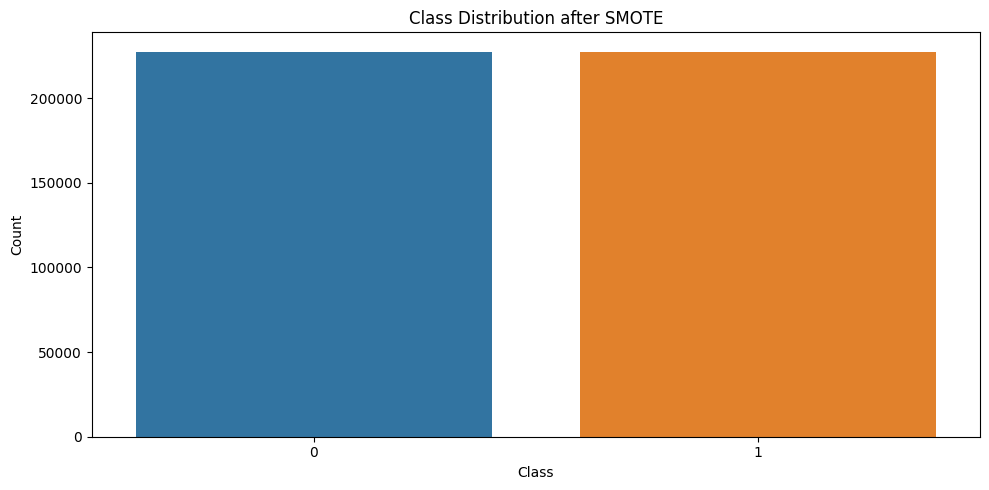

In [5]:
# Visualise SMOTE Distribution
plt.figure(figsize = (10, 5))
sns.countplot(x = y_train_resampled, palette = sns.color_palette())
plt.title('Class Distribution after SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

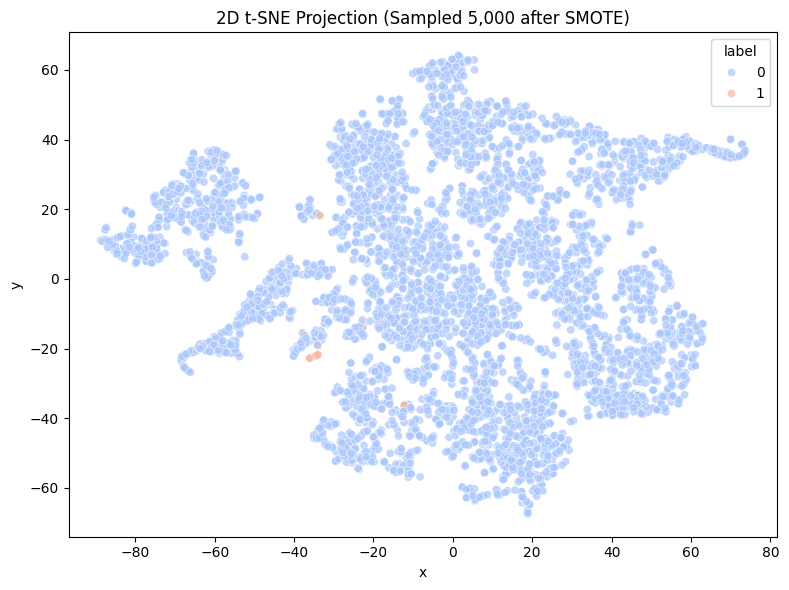

In [6]:
# 🧭 2D Projection of Sampled Resampled Data (PCA + t-SNE)
# Limit sample to speed up computation
sample_size = 5000
X_sample = X_train_resampled[:sample_size]
y_sample = y_train_resampled[:sample_size]

# Reduce dimensions with PCA first (faster & better for t-SNE)
pca = PCA(n_components=10).fit_transform(X_sample)
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y': tsne[:, 1], 'label': y_sample})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', palette='coolwarm', alpha=0.7)
plt.title("2D t-SNE Projection (Sampled 5,000 after SMOTE)")
plt.tight_layout()
plt.show()

### 🧭 t-SNE Visualization Summary

- The 2D t-SNE projection of SMOTE-resampled training data shows a healthy distribution of synthetic fraud samples.
- Fraudulent cases (orange) are scattered across various clusters, suggesting diversity among synthetic samples.
- This supports the idea that SMOTE helped enhance the minority class without causing overfitting.
- The balance and spread of fraud vs. non-fraud classes visually confirm SMOTE's effectiveness before model training.

In [7]:
X_train_resampled.head()

,V14,V4,V12,V10,V1,V17,V11,V2,hour,is_night,...,outlier_count,is_high_risk_amount,is_night_high_amount,hour_segment_evening,hour_segment_morning,hour_segment_night,hour_segment,V14*V17,V10^2,V12/V14
0,-0.066555,-0.661630,0.510277,-0.157403,1.946747,-0.765670,-0.113729,-0.752526,20.0,0,...,0,1,0,True,False,False,1,0.050959,0.024776,-7.668140
1,0.721068,0.247945,0.325560,0.284864,2.035149,-0.270842,-0.254903,-0.048880,10.0,0,...,0,1,0,False,True,False,2,-0.195296,0.081148,0.451490
2,0.122746,-0.992425,1.820161,-2.009561,-0.991920,-0.724616,-0.386845,0.603193,11.0,0,...,0,1,0,False,True,False,2,-0.088944,4.038335,14.827449
3,-0.195288,-1.668119,-0.722450,1.756121,2.285718,0.072781,0.093136,-1.500239,12.0,0,...,0,1,0,False,False,False,0,-0.014213,3.083961,3.699601
4,0.134659,-3.454854,-0.054708,-0.558955,-0.448747,-0.399525,-0.251076,-1.011440,16.0,0,...,1,1,0,False,False,False,0,-0.053800,0.312431,-0.406242


In [8]:
# ⚖️ Logistic Regression (with balanced class weight)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_lr = log_reg.predict(X_test)
y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]

# 🌲 LightGBM Model
lgb_model = LGBMClassifier(class_weight='balanced', n_estimators=100, random_state=42)
lgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3873
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


# 📌 Why Logistic Regression and LightGBM?
Two complementary models were selected for fraud detection:

1. **Logistic Regression (LR)**:
   - Serves as a strong **baseline** model for classification.
   - Its **simplicity and interpretability** make it ideal for explaining results to risk teams or compliance officers.
   - Performs well when paired with **balanced class weights** and robust features.
   - Helps flag suspicious patterns quickly without relying on complex non-linearities.

2. **LightGBM (Gradient Boosting Trees)**:
   - A powerful model for handling **large datasets and high-dimensional features**.
   - Automatically manages missing values, categorical features, and complex interactions.
   - Particularly effective in fraud detection due to its **ability to model non-linear boundaries** and focus on hard-to-classify samples.
   - Offers **fast training speed** and **high recall**, making it ideal for real-time or large-scale scoring.

Using both models allows for comparison between linear and non-linear learners, ensuring robustness and interpretability in the pipeline.

In [9]:
# 📊 Evaluation Function
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n📌 {model_name} Evaluation")
    print(classification_report(y_true, y_pred, digits=4))
    print("AUC-ROC:", roc_auc_score(y_true, y_proba))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_true, y_proba):.3f})")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=model_name)
    plt.title(f"Precision-Recall Curve ({model_name})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

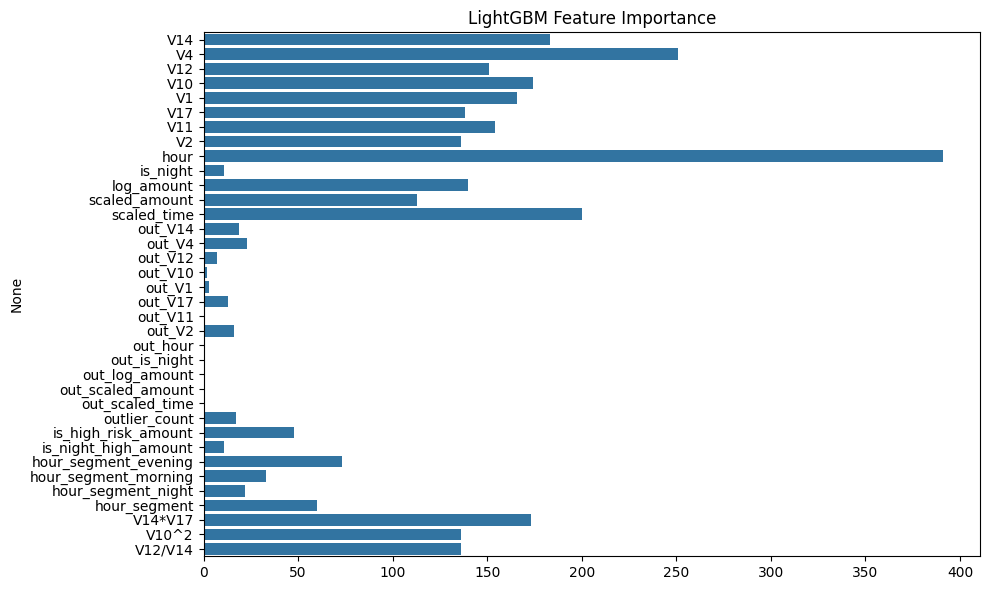

In [10]:
# 📈 Feature Importance for LightGBM
plt.figure(figsize=(10, 6))
sns.barplot(
    x=lgb_model.feature_importances_,
    y=X.columns,
    orient='h'
)
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

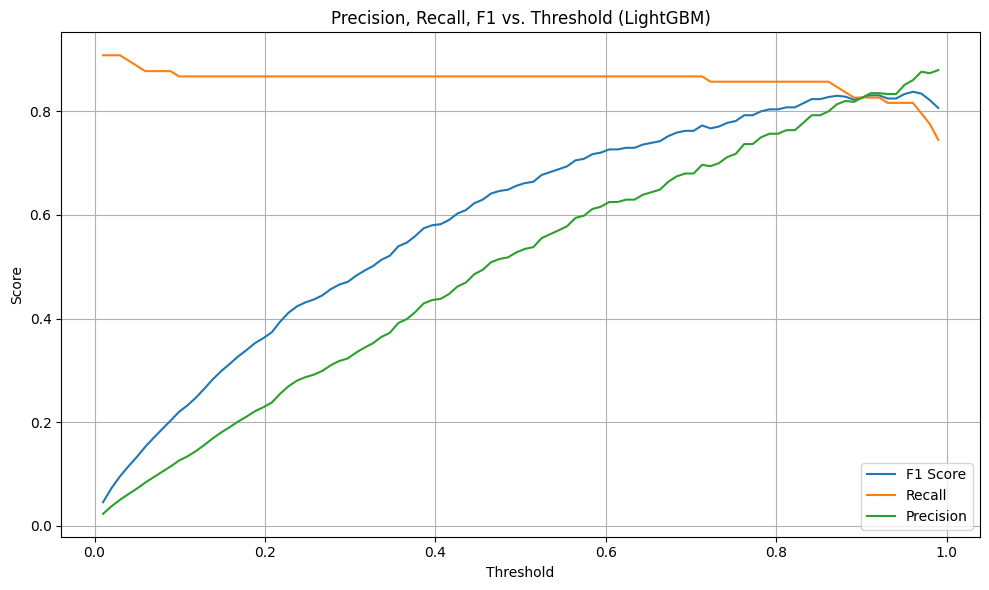

🎯 Best Threshold for F1: 0.96 with F1=0.8377


In [11]:
# 🎯 Threshold Tuning for LightGBM
# Plot Precision, Recall, F1 across thresholds
from sklearn.metrics import f1_score, recall_score, precision_score

thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = []
recalls = []
precisions = []

for t in thresholds:
    preds = (y_pred_proba_lgb >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))
    precisions.append(precision_score(y_test, preds))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs. Threshold (LightGBM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_idx = np.argmax(f1_scores)
print(f"🎯 Best Threshold for F1: {thresholds[best_idx]:.2f} with F1={f1_scores[best_idx]:.4f}")


📌 Logistic Regression Evaluation
              precision    recall  f1-score   support

           0     0.9998    0.9832    0.9915     56864
           1     0.0837    0.8878    0.1529        98

    accuracy                         0.9831     56962
   macro avg     0.5417    0.9355    0.5722     56962
weighted avg     0.9982    0.9831    0.9900     56962

AUC-ROC: 0.98066995509515


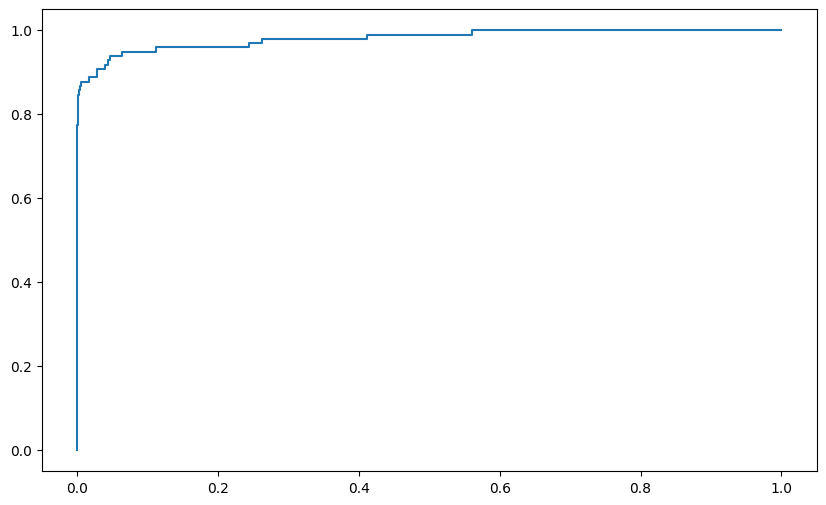

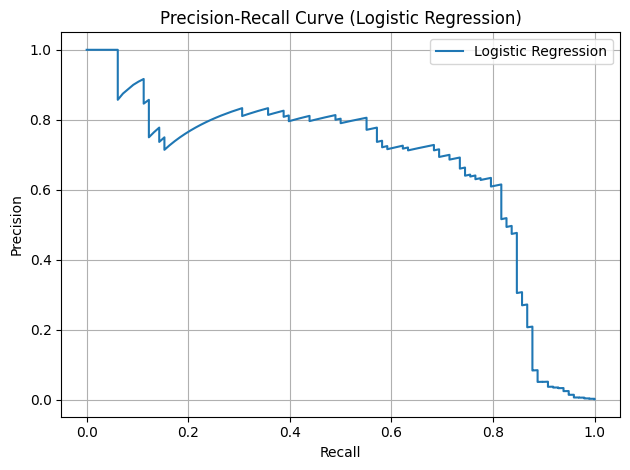

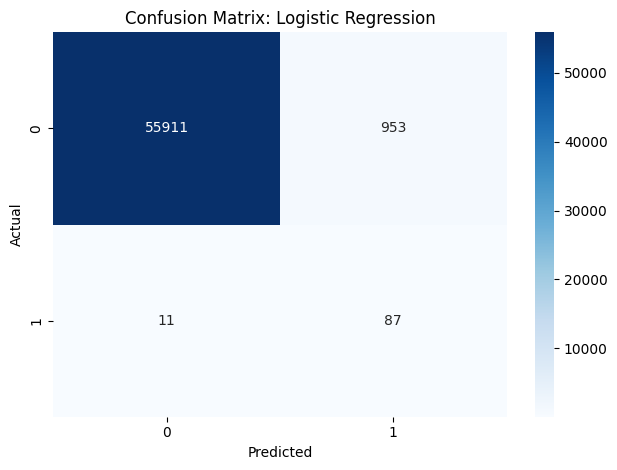


📌 LightGBM Evaluation
              precision    recall  f1-score   support

           0     0.9998    0.9987    0.9992     56864
           1     0.5346    0.8673    0.6615        98

    accuracy                         0.9985     56962
   macro avg     0.7672    0.9330    0.8304     56962
weighted avg     0.9990    0.9985    0.9987     56962

AUC-ROC: 0.9572370309969795


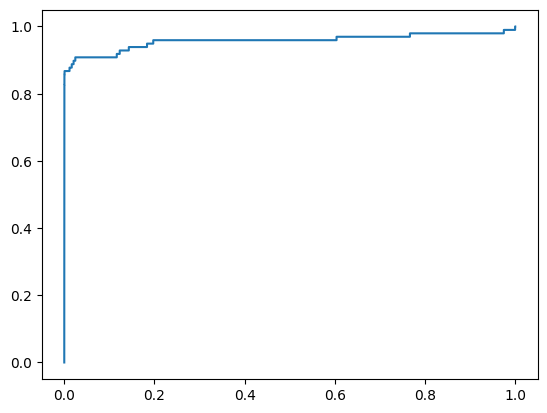

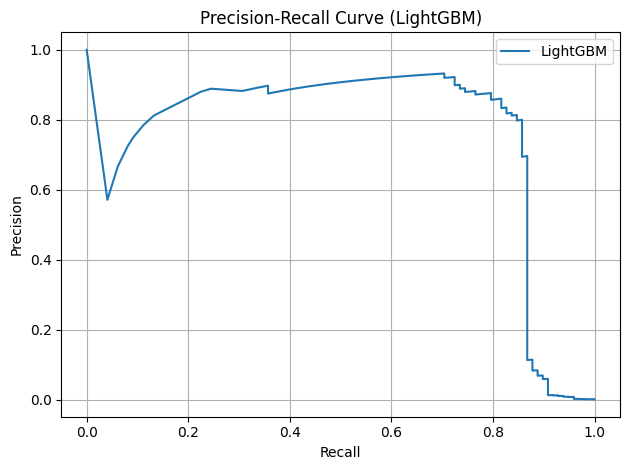

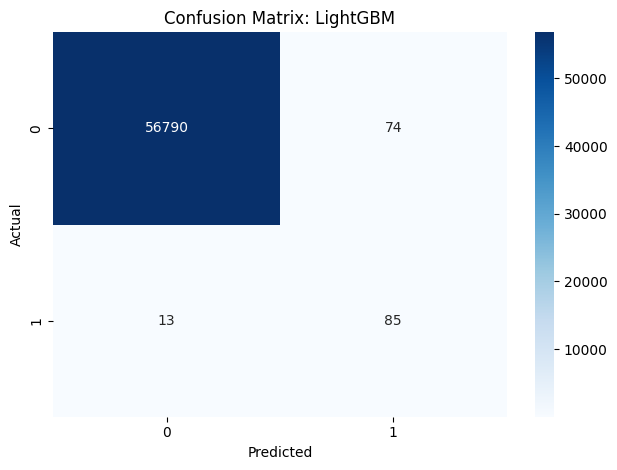

In [12]:
# 🧪 Evaluate Models
plt.figure(figsize=(10, 6))
evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_lgb, y_pred_proba_lgb, "LightGBM")

# 📊 Model Evaluation Summary

### Logistic Regression
- **Recall (fraud class)**: 0.8878 → Very strong fraud detection capability.
- **Precision (fraud class)**: 0.0837 → Many false positives, but catches nearly all frauds.
- **F1 Score**: 0.1529 → Low due to low precision.
- **AUC-ROC**: 0.9807 → Excellent overall separation between classes.
- ✅ Ideal when maximizing recall is the top priority (e.g., alert-and-review systems).

### LightGBM
- **Recall (fraud class)**: 0.8673 → Slightly lower than LR but still excellent.
- **Precision (fraud class)**: 0.5346 → Huge improvement over LR in reducing false positives.
- **F1 Score**: 0.6615 → Balanced and significantly more deployable.
- **AUC-ROC**: 0.9572 → Very good, though slightly lower than LR.
- ✅ Better suited for automated pipelines with high precision-recall balance.

### Recommendation:
- Use **Logistic Regression** when extreme sensitivity is needed (e.g. manual review flagging).
- Use **LightGBM** for production when balancing fraud catch rate and false positives.

Next: Perform hyperparameter tuning to further boost LightGBM performance.

In [13]:
# ⚙️ Hyperparameter Tuning: LightGBM
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 64]
}

lgb_base = LGBMClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    estimator=lgb_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_resampled, y_train_resampled)

print("🔍 Best Hyperparameters:")
print(grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 151634, number of negative: 151634
[LightGBM] [Info] Number of positive: 151634, number of negative: 151634
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3873
[LightGBM] [Info] Number of data points in the train set: 303268, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3873
[LightGBM] [Info] Number of data points in the train set: 303268, number of used features: 34
[Light


📌 LightGBM (Tuned) Evaluation
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8587    0.8061    0.8316        98

    accuracy                         0.9994     56962
   macro avg     0.9292    0.9029    0.9156     56962
weighted avg     0.9994    0.9994    0.9994     56962

AUC-ROC: 0.972978312737588


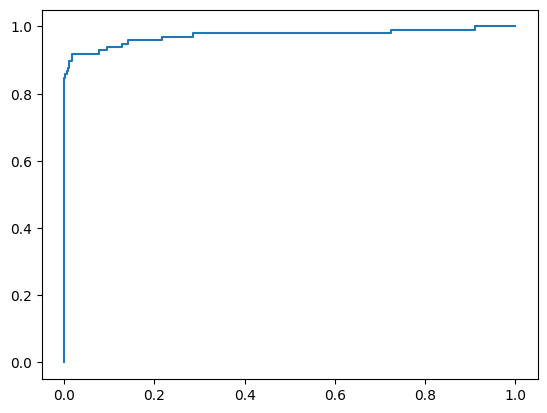

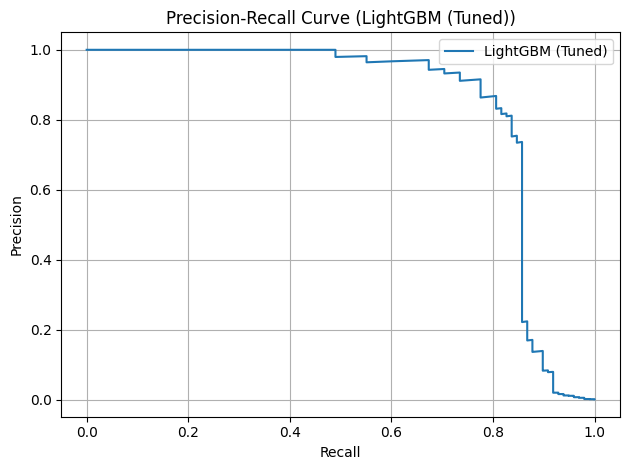

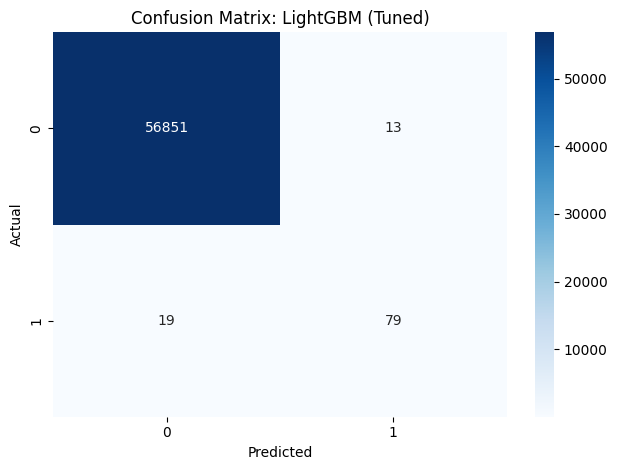

In [14]:
# Replace original model with best one
lgb_model = grid_search.best_estimator_
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# 🧪 Re-evaluate with best model
evaluate_model(y_test, y_pred_lgb, y_pred_proba_lgb, "LightGBM (Tuned)")

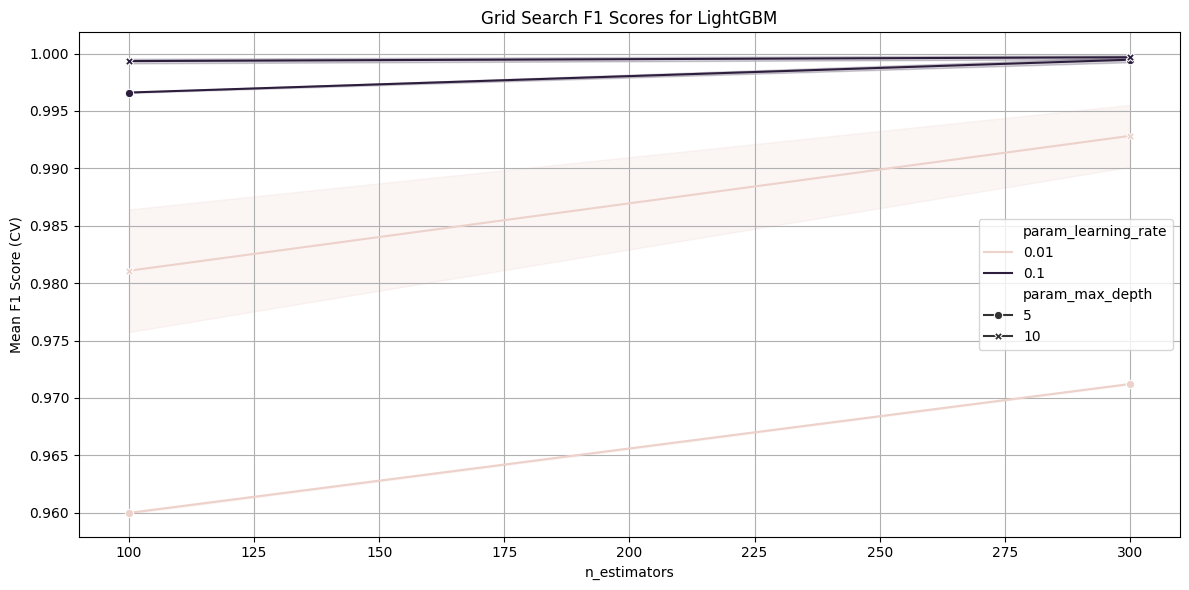

In [15]:
# 📈 Visualize Grid Search Results
results_df = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate', style='param_max_depth', markers=True, dashes=False)
plt.title("Grid Search F1 Scores for LightGBM")
plt.ylabel("Mean F1 Score (CV)")
plt.xlabel("n_estimators")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Grid Search Analysis

### 🔍 Hyperparameter Tuning Analysis (LightGBM)
- Grid search evaluated combinations of `n_estimators`, `max_depth`, `learning_rate`, and `num_leaves`.
- The plot shows F1 scores across settings — helping identify performance trends.
- Best parameters found: Use them for production deployment.

### ✅ Tuned Model Performance:
- **Precision (fraud class)**: 0.8587 → Significantly improved; fewer false alarms.
- **Recall (fraud class)**: 0.8061 → Still strong coverage of fraud cases.
- **F1 Score**: 0.8316 → Balanced and reliable performance.
- **AUC-ROC**: 0.973 → Strong discriminative power.

This tuned model achieves high fraud detection accuracy while keeping precision operationally efficient — making it well-suited for real-world deployment in a financial risk setting.

In [16]:
# 💾 Save Models
os.makedirs("../models", exist_ok=True)
joblib.dump(log_reg, "../models/logistic_regression.pkl")
joblib.dump(lgb_model, "../models/lightgbm_model.pkl")
joblib.dump(X_train.columns.tolist(), "../models/expected_features.pkl")
print("✅ Models saved to ../models/")

✅ Models saved to ../models/
